# Práctico 1
- Levantar los datos desde el archivo dataset/Telefonia_movil.csv. Los mismos fueron extraídos de http://datosabiertos.enacom.gob.ar/visualizations/29890/trafico-de-suscriptores-de-telefonia-movil-miles-de-minutos/
- Explorar los datos, visualizarlos.
- Implementar dos modelos (como ser Random Walk (Naïve) y Exponential Smoothing).
- Visualizar los resultados y evaluarlos, comparando ambas implementaciones.

In [1]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os
from plotting import fanchart

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

In [3]:
df = pd.read_csv('./datasets/Telefonia_movil.csv',
                 dtype={'Año':str,'Trimestre':str},
                 thousands='.').rename(columns={'Minutos pospago salientes (miles)': 'min_pospago',
                                         'Minutos prepago salientes (miles)': 'min_prepago',
                                        'Total de minutos salientes (miles)':'total'})
df.head()

,Año,Trimestre,min_pospago,min_prepago,total,Periodo
0,2013,1,8785943,6582117,15368060,Ene-Mar 2013
1,2013,2,9512689,7108640,16621329,Abr-Jun 2013
2,2013,3,10315484,7335154,17650638,Jul-Sept 2013
3,2013,4,9809515,6250549,16060064,Oct-Dic 2013
4,2014,1,10128751,5799223,15927974,Ene-Mar 2013


In [4]:
df.index = pd.PeriodIndex(list(df['Año']+ 'Q' +df['Trimestre']), freq='Q')

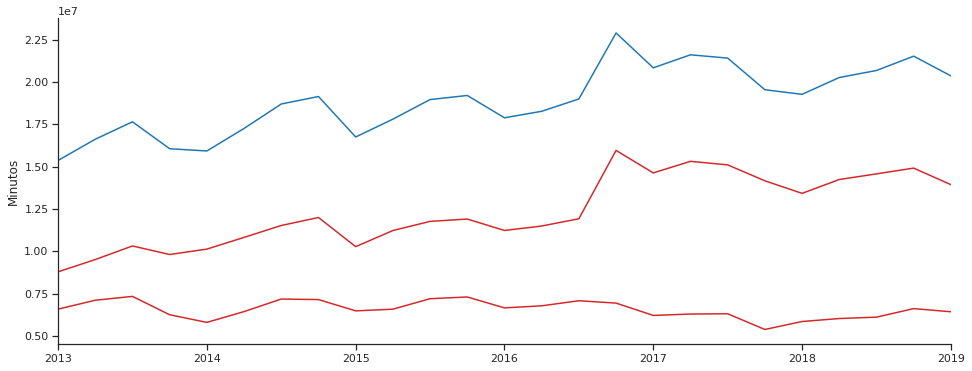

In [44]:
fig, ax = plt.subplots(figsize = (16, 6))
df['min_pospago'].plot(color=red, label = 'Pospago')
df['min_prepago'].plot(color = red, label = 'Pospago')
df['total'].plot(color = blue, label = 'Total')
ax.set_xlabel('')
ax.set_ylabel('Minutos')
ax.set_title('')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
plt.show()

###### Minutos totales

In [8]:
print(df['total'].describe().round(2))

count          25.00
mean     18922204.72
std       1982378.31
min      15368060.00
25%      17650638.00
50%      19001229.00
75%      20364355.00
max      22899656.00
Name: total, dtype: float64


### Análisis exploratorio

In [16]:
h = 4
test_total = pd.period_range(start = df['total'].index[-1] + 1,
                               periods = h,
                               freq = 'Q')
pred_total = pd.Series(np.repeat(df['total'].iloc[-1], h),
                         index = test_pospago)

###### Desvíos

In [17]:
resid_total = df['total'] - df['total'].shift(1)
sigma_total = resid_total.std()
desv_total = round(sigma_total, 3)

print('\
Desvío total:\t{}\n\
'.format(desv_total))

Desvío total:	1409600.295



###### Intervalos de confianza

In [19]:
intv_total = pd.concat([pred_total - stats.norm.ppf(0.975) * sigma_total * np.sqrt(np.arange(1, h + 1)),
                        pred_total + stats.norm.ppf(0.975) * sigma_total * np.sqrt(np.arange(1, h + 1))],
                       axis = 1).round(3)
print('\
Intervalo total:\t{}\n\n\
'.format(intv_pospago))

Intervalo total:	                   0             1
2019Q2  1.175970e+07  1.611484e+07
2019Q3  1.085772e+07  1.701682e+07
2019Q4  1.016560e+07  1.770894e+07
2020Q1  9.582125e+06  1.829242e+07




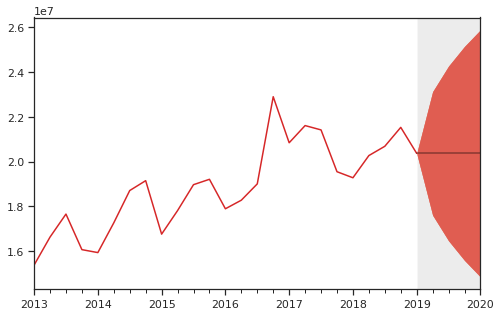

In [20]:
point_pred = (intv_total[0]+intv_total[1])/2
fig, ax = fanchart(df['total'],
                   point_pred,
                   intv_total,
                   intv_total,
                   intv_total)
plt.show()

##### Simple exponential smoothing

In [24]:
model_ses = sm.tsa.SimpleExpSmoothing(df['total'].astype(np.float)).fit()
fitted_ses = model_ses.fittedvalues
model_ses.summary()

Dep. Variable:,endog,No. Observations:,25
Model:,SimpleExpSmoothing,SSE,43486319814188.438
Optimized:,True,AIC,708.615
Trend:,None,BIC,711.053
Seasonal:,None,AICC,710.615
Seasonal Periods:,None,Date:,"Mon, 30 Sep 2019"
Box-Cox:,False,Time:,20:42:04
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5589059,alpha,True
initial_level,1.5819e+07,l.0,True


In [25]:
mse_ses = sm.tools.eval_measures.mse(df['total'],fitted_ses)
print(' In-sample fit:')
print(' MSE               {0:.3f}'.format(mse_ses))

 In-sample fit:
 MSE               1739452792567.538


In [26]:
N = len(df['total'])
loglik_ses=-(N/2)*(1+np.log(2*np.pi))-(N/2)*np.log(mse_ses)
aic_ses=-2*loglik_ses+2*3
bic_ses=-2*loglik_ses+np.log(N)*3
print(' Log-likelihood    %.3f' % (loglik_ses))
print(' AIC               {0:.3f}'.format(aic_ses))
print(' BIC               {0:.3f}'.format(bic_ses))

 Log-likelihood    -387.781
 AIC               781.562
 BIC               785.218


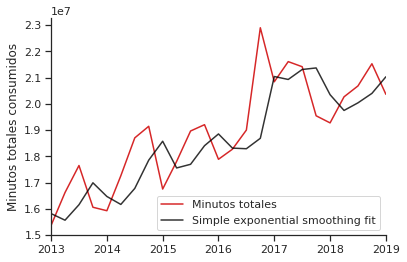

In [29]:
fig, ax= plt.subplots();#figsize=(9,6))
df['total'].plot(color=red, label='Minutos totales')
fitted_ses.plot(color='black', label='Simple exponential smoothing fit', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel('Minutos totales consumidos')
ax.set_title('')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

#### Análisis de resultados

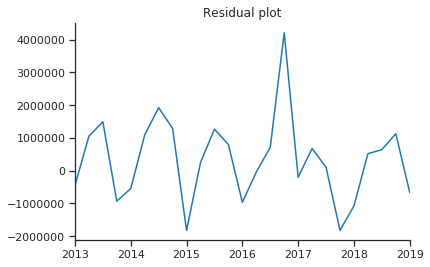

In [31]:
resid = df['total'] - fitted_ses 
fig, ax= plt.subplots();#figsize=(9,6))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

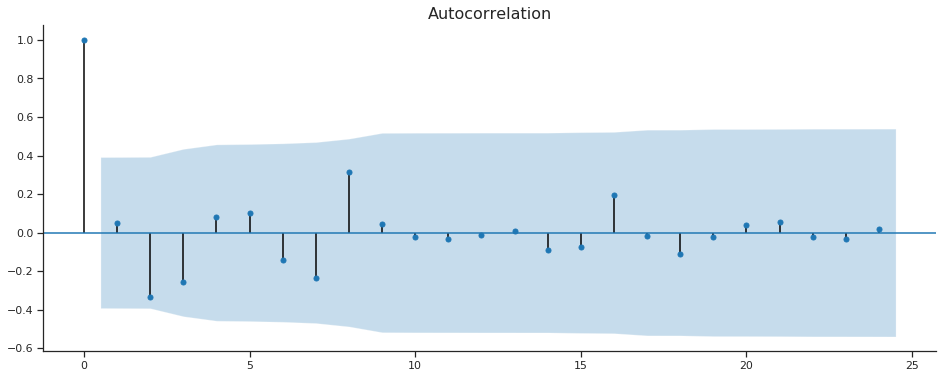

In [34]:
fig, ax = plt.subplots(figsize = (16, 6))
sm.graphics.tsa.plot_acf(resid, lags = 24, ax = ax)
ax.set_title('Autocorrelation', fontsize = 16)
sns.despine()
plt.show()

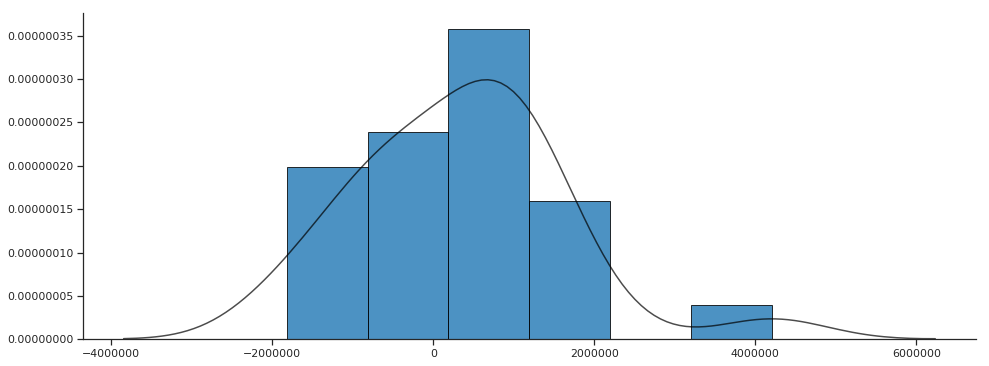

In [35]:
def hist(series):
    fig, ax = plt.subplots(figsize = (16, 6))
    plt.ticklabel_format(style = 'plain')
    
    sns.distplot(series, ax = ax, hist_kws = {'alpha': 0.8, 'edgecolor':'black', 'color': blue},  
                 kde_kws = {'color': 'black', 'alpha': 0.7})
    
    sns.despine()
    return fig, ax

hist(resid)
plt.show()

#### Validación del modelo

In [38]:
validation = df['total']['2014Q1':].index # the validation period is Q1 2014 onwards
start = df['total'].index.get_loc('2014Q1') # numerical index corresponding to Q1 2015

pred1 = []
pred2 = []
actual= []
for i in range(start, len(df['total'])):
    
    actual.append(df['total'].iloc[i]) # actual value
    
    pred1.append(df['total'].iloc[i-1]) # random walk forecast
    
    model = sm.tsa.SimpleExpSmoothing(df['total'].astype(float).iloc[:i]).fit() 
    pred2.append(model.forecast(1)[0]) # SES forecast

columns=['RW', 'SES', 'Actual']
results_sm = np.vstack([pred1, pred2, actual]).T
results_sm = pd.DataFrame(results_sm, columns = columns, index = validation)
results_sm.tail()

/home/alain/miniconda3/envs/diplo/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


,RW,SES,Actual
2018Q1,19545262.0,2.036284e+07,19274565.0
2018Q2,19274565.0,1.967908e+07,20267591.0
2018Q3,20267591.0,2.003145e+07,20682782.0
2018Q4,20682782.0,2.041573e+07,21528745.0
2019Q1,21528745.0,2.113715e+07,20364355.0


In [39]:
from scipy import stats
table = pd.DataFrame(0.0, index = results_sm.columns[:-1], columns = ['RMSE', 'SE'])
for i in range(2):
    table.iloc[i, 0] = sm.tools.eval_measures.rmse(results_sm.iloc[:, i], results_sm.iloc[:, -1])
    table.iloc[i, 1] = (results_sm.iloc[:, i] - results_sm.iloc[:, -1]).sem()
    
table.round(3)

,RMSE,SE
RW,1407131.775,311288.345
SES,1505145.822,331214.132


#### Forecasting

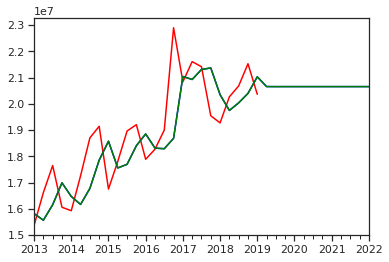

In [43]:
h=12
w=h*10
data = df['total']
model = sm.tsa.SimpleExpSmoothing
pred_index = df['total'].index[-1] + np.array(range(1,h+1))
pred_rolling = pd.Series(0,index=pred_index)
pred_expanding = pd.Series(0,index=pred_index)
orig_exp = None
orig_roll = None
for i in range(0,h):
    current_exp = pd.concat([data, pred_expanding.head(i)]).astype(float)
    expanding = model(current_exp).fit()
    pred_expanding.update(expanding.forecast(1))
    current_roll = pd.concat([data, pred_rolling.head(i)]).astype(float)
    rolling = model(current_roll.tail(w)).fit()
    pred_rolling.update(rolling.forecast(1))
    if i==0:
        orig_fit = expanding.fittedvalues
        orig_roll = rolling.fittedvalues
ax = data[-w:].plot(color='red');#figsize=(9,6))
pd.concat([orig_fit[-w:],pred_expanding]).plot(ax=ax,color='blue');
pd.concat([orig_roll[-w:],pred_rolling]).plot(ax=ax,color='green');